In [1]:
import os
import gc
import sys
import copy
import math
import codecs
import pickle
from glob import glob
from datetime import datetime
import operator
import re
import random
import string
from collections import Counter

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.io
from scipy.io import loadmat
from scipy.signal import resample, periodogram, savgol_filter, butter, lfilter, welch, spectrogram
from scipy.integrate import simps

from tqdm import tqdm, tqdm_notebook
import mne
from mne import Epochs, create_info, find_events, pick_types
from mne.channels import read_montage
from mne.io import RawArray
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import backend as K
# from tensorflow.keras.constraints import max_norm
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv1D, Conv2D, Dense, Dropout, MaxPool1D, MaxPool2D, MaxPooling2D, Activation, AveragePooling2D
# from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
# from tensorflow.keras.layers import CuDNNGRU, CuDNNLSTM
# from tensorflow.keras.layers import concatenate
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
# from tensorflow.keras.utils import to_categorical
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate, cross_val_score, KFold
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, FunctionTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectPercentile, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
import pywt
import xgboost as xgb
import pydicom

In [4]:
DATA_FD = "./data"
TRAIN_FD = "./data/dicom-images-train/"
TEST_FD = "./data/dicom-images-test/"
TRAIN_LABEL = "./data/train-rle.csv"

In [197]:
train_fns = sorted(glob(os.path.join(TRAIN_FD, "*/*/*.dcm")))

In [129]:
# train_fns[0]

In [200]:
len(train_fns)

10712

### Utils

In [119]:
def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

def show_dcm_info(dataset):
#     print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

In [198]:
df = pd.read_csv(TRAIN_LABEL)

In [148]:
raw = pydicom.dcmread(train_fns[2])

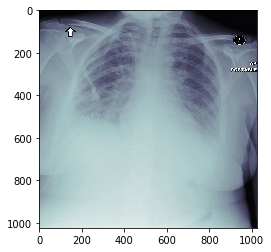

In [149]:
plt.imshow(raw.pixel_array, cmap=plt.cm.bone)

In [150]:
mask = rle2mask(df.iloc[2][" EncodedPixels"], 1024, 1024).T

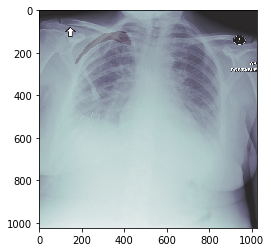

In [151]:
plt.imshow(raw.pixel_array, cmap=plt.cm.bone);
plt.imshow(mask, alpha=0.15, cmap="Reds");

### Create bbox

- Reference: https://www.kaggle.com/freeman89/eda-can-you-see-the-pneumothorax

In [226]:
from matplotlib import patches as patches

def plot_with_mask_and_bbox(dataset, mask_encoded, figsize=(20,10)):
    mask_decoded = rle2mask(mask_encoded, 1024, 1024).T
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
    rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
    patch = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
    ax[0].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    ax[0].imshow(mask_decoded, alpha=0.3, cmap="Reds")
    ax[0].add_patch(patch)
    ax[0].set_title('With Mask')

    patch = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
    ax[1].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    ax[1].add_patch(patch)
    ax[1].set_title('Without Mask')
    plt.show()

def plot_pixel_array(dataset, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()    
    
def show_bb_image(fn_path):
    image_id = fn_path.split('/')[-1][:-4]
    dataset = pydicom.dcmread(fn_path)
    
    masks = df[df["ImageId"].isin([image_id])][" EncodedPixels"].values
    for mask in masks:
        if mask.strip() == '-1':    
            plot_pixel_array(dataset)
        else:
            plot_with_mask_and_bbox(dataset, mask)

In [233]:
# show_bb_image(train_fns[30])

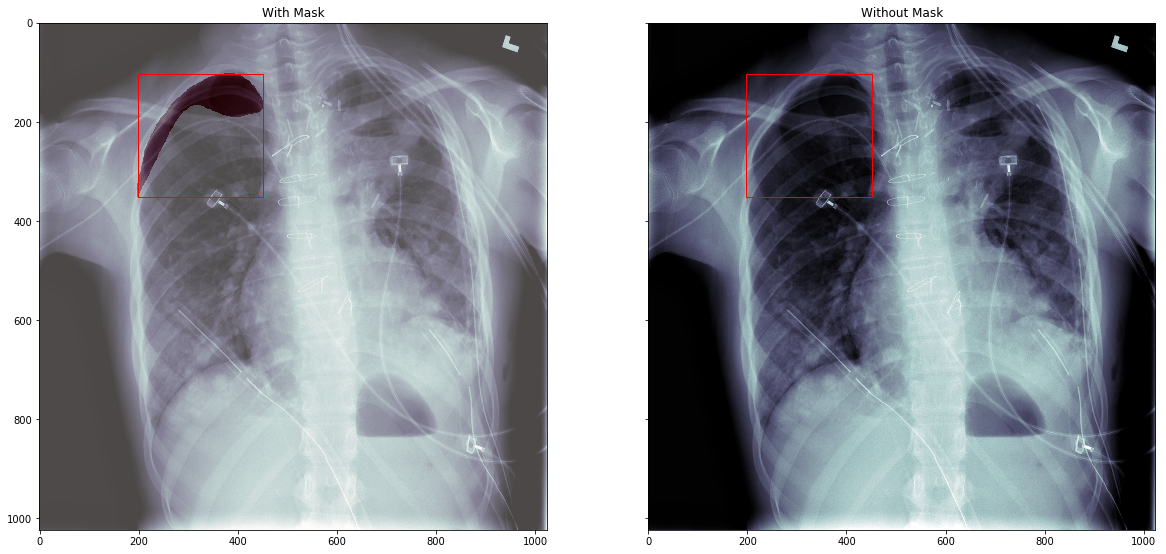

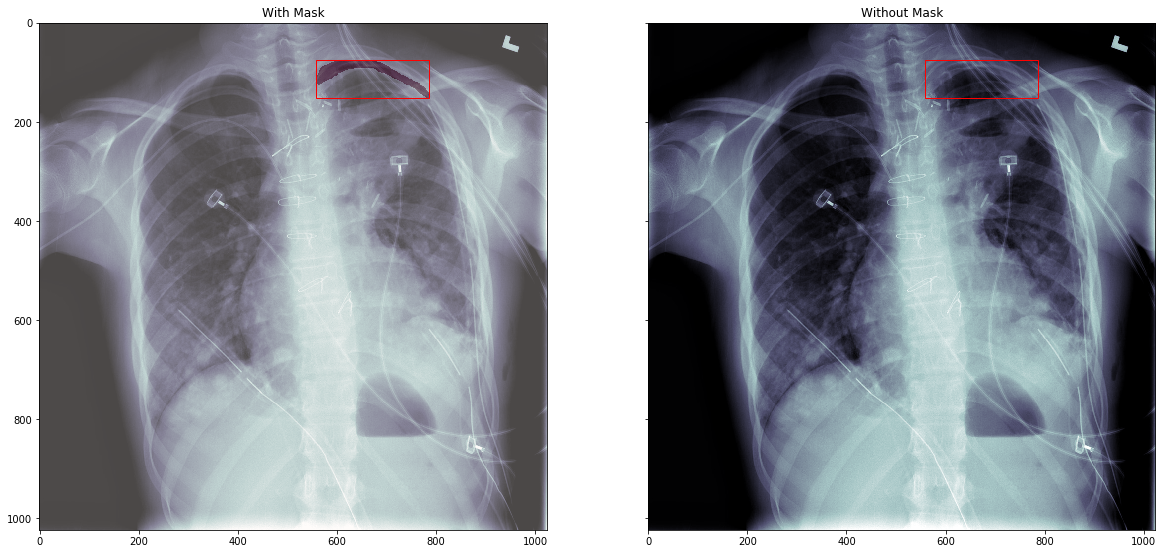

In [227]:
show_bb_image("./data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.32603.1517875161.429988/1.2.276.0.7230010.3.1.3.8323329.32603.1517875161.429987/1.2.276.0.7230010.3.1.4.8323329.32603.1517875161.429989.dcm")

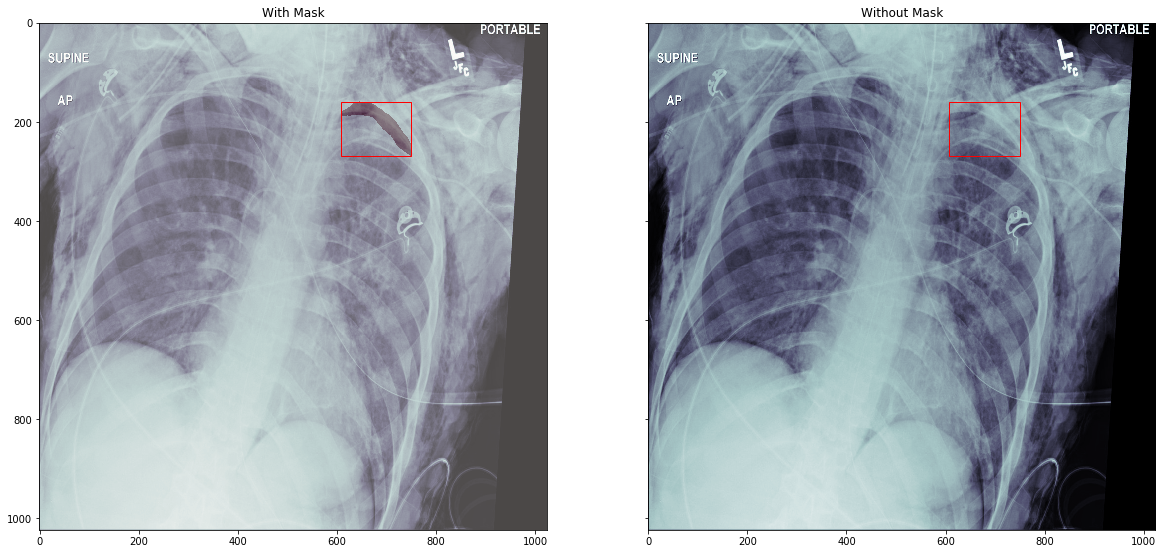

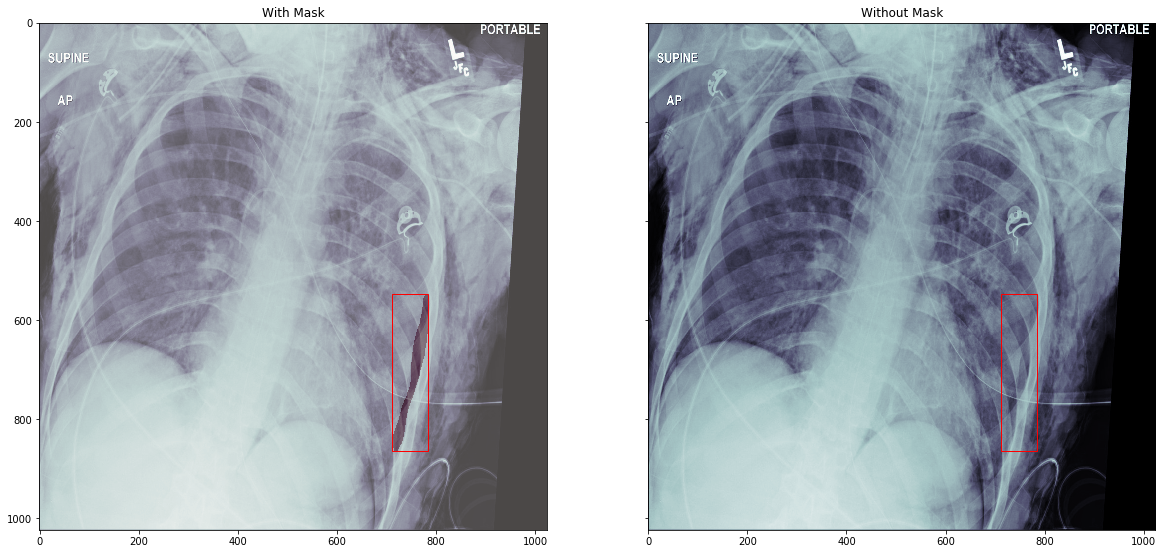

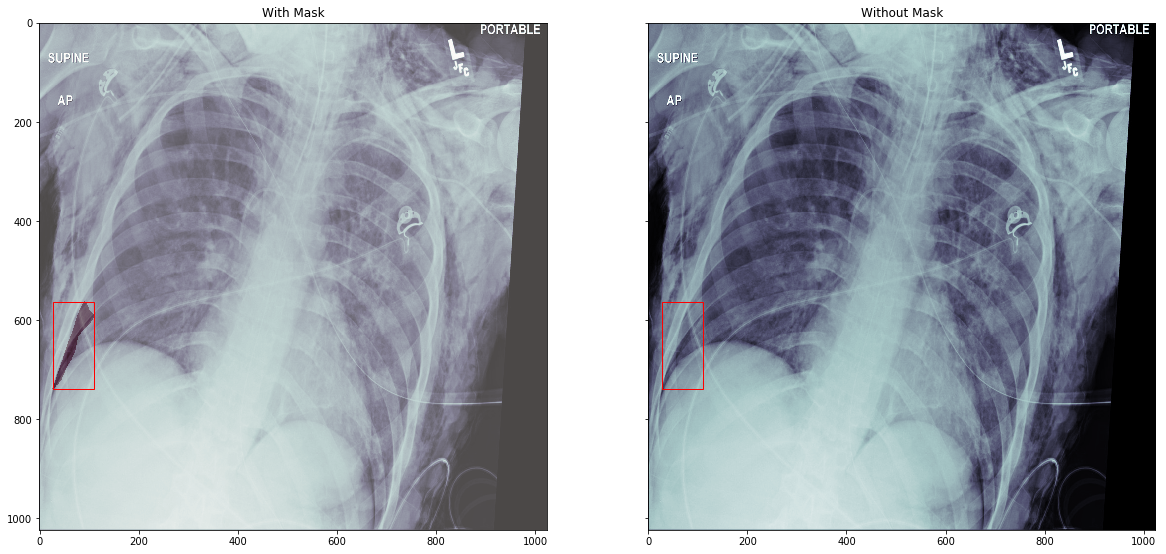

In [231]:
show_bb_image("./data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10287.1517875222.997106/1.2.276.0.7230010.3.1.3.8323329.10287.1517875222.997105/1.2.276.0.7230010.3.1.4.8323329.10287.1517875222.997107.dcm")

### Show masks

In [239]:
def show_mask(fn_path, IMG_SIZE=1024, alpha=0.25, mask=True):
    raw = pydicom.dcmread(fn_path)
    image_id = fn_path.split('/')[-1][:-4]
    rfes = df[df["ImageId"].isin([image_id])][" EncodedPixels"].values  #[0]
    
    plt.imshow(raw.pixel_array, cmap=plt.cm.bone);
    if rfes[0] != " -1":
        if mask:
            for rfe in rfes:
                plt.title('{} Marker\n{}'.format(len(rfes), ".".join([i for i in image_id.split(".")[-3:]])))
                mask = rle2mask(rfe, IMG_SIZE, IMG_SIZE).T
                plt.imshow(mask, alpha=alpha, cmap="Reds");
    else:
        plt.title('No mask')

1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027


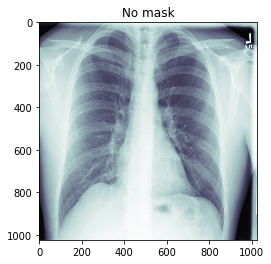

In [215]:
show_mask(train_fns[0], mask=False)

1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027


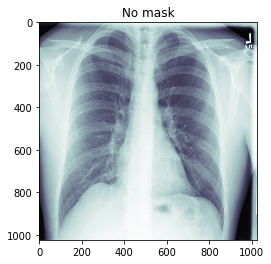

In [216]:
show_mask(train_fns[0], mask=True)

In [240]:
def show_masks(fn_paths, columns=4, rows=4, alpha=0.25, verbose=True):
    fig = plt.figure(figsize=(5*columns, 4*rows))

    for i, fn_path in zip(range(columns*rows), fn_paths):
        try:
            if verbose:
                print(fn_path.split('/')[-1][:-4])

            fig.add_subplot(rows, columns, i+1)
            show_mask(fn_path, alpha=alpha, mask=True)
        except IndexError:
            plt.tight_layout()
            break
    
    plt.tight_layout()

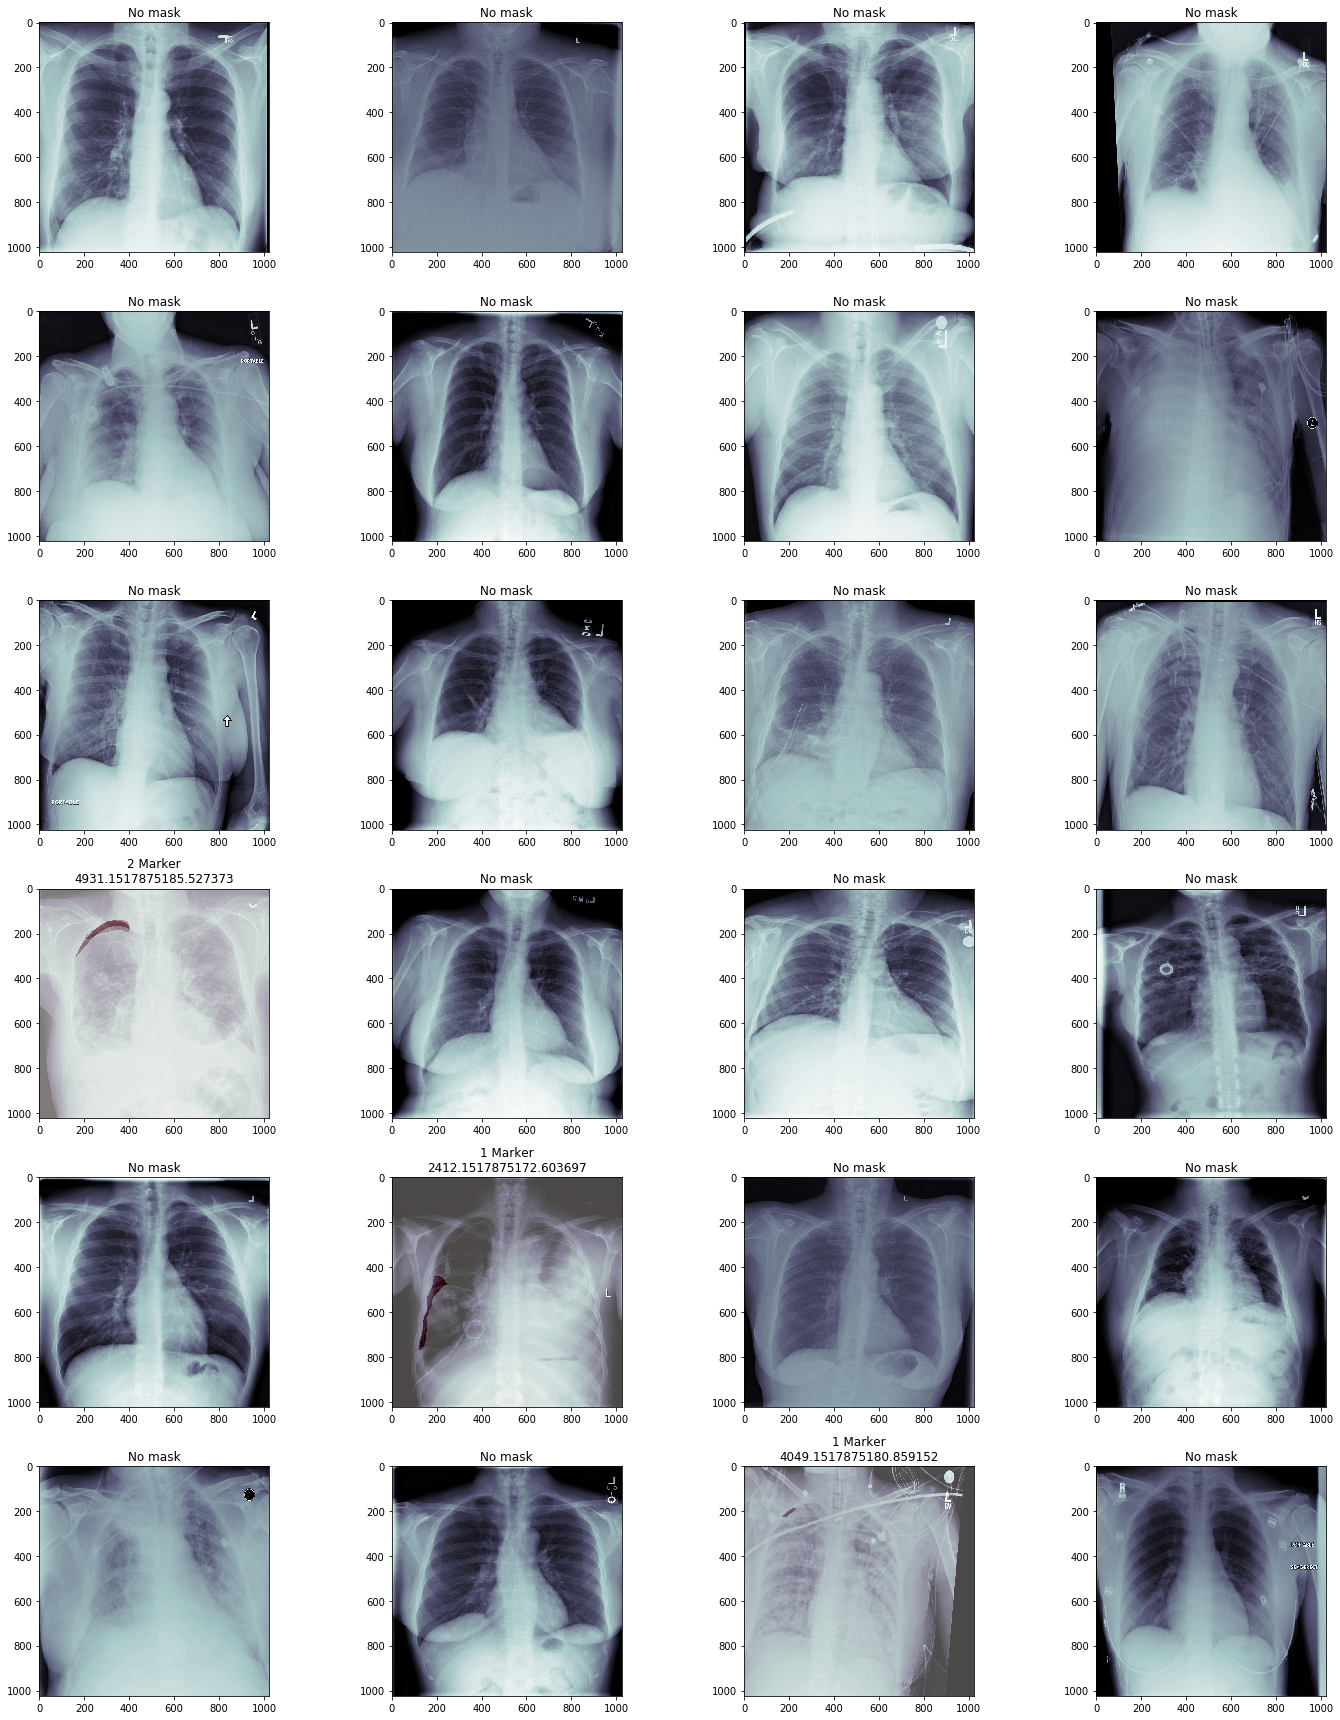

In [241]:
show_masks(random.sample(train_fns, 2000), 4, 6, 0.30, verbose=False)